## Overview

1. [Single Cell Model](#single-cell-model)
2. [Network Simulations](#network-simulations)
3. [Fit of the Transfer Function](#fit-of-the-transfer-function)
4. [Mean Field Model](#mean-field-model)
5. [Whole Brain Model](#whole-brain-model)
6. [PCI](#pci)
7. [BOLD and FC](#bold-and-fc)
8. [Dynamical Analysis](#dynamical-analysis)

In [1]:
%precision 2
%load_ext autoreload
%autoreload 2

In [2]:
%run setup.py

Everything is now installed. You can proceed. 


<a class="anchor" id="single-cell-model"></a>
### Single Cell Model

In this implementations we select the **AdEx model**, described as following: 


$c_{m}  \frac{dv}{dt}  =  g_L(E_L-v)+ g_L\Delta e^{\frac{v-v_{thr}}{\Delta }} -W + I_{syn}$  

$\frac{dW}{dt}  =  -\frac{1}{\tau_w} (a(v-E_L) - W) + b \sum_{t_{sp}}\delta(t-t_{sp})$

These equations are used in the `eqs` variable of the Brian implementation.

You can select a different model and adjust the `eqs` and the relevant parameters of the model accordingly.

In [3]:
#These are the arguments and default values - to try different parameters refer to the script
%run single_cell_sim.py --help

usage: single_cell_sim.py [-h] [--type TYPE] [--b_e B_E] [--iext IEXT]
                          [--tau_e TAU_E] [--tau_i TAU_I] [--time TIME]

optional arguments:
  -h, --help     show this help message and exit
  --type TYPE    type of cell (RS or FS) (default: RS)
  --b_e B_E      adaptation (pA) (default: 60)
  --iext IEXT    input current (nA) (default: 0.3)
  --tau_e TAU_E  excitatory synaptic decay (ms) (default: 5.0)
  --tau_i TAU_I  inhibitory synaptic decay (ms) (default: 5.0)
  --time TIME    Total Time of simulation (ms) (default: 200)


Simulation of a single neuron. In this case we simulate the activity of a regular spiking cell, with adaptation.

cell parameters --NOT-- in SI units
dict_keys(['use', 'b'])


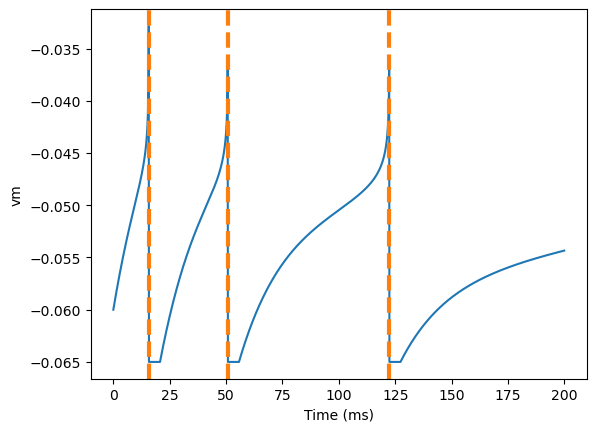

In [20]:
%run single_cell_sim_copy.py --type='RS' --kwargs '{"use": True, "b":85}'

<a id="network-simulations"></a>
### Network Simulations

In [26]:
#These are the arguments and default values - for more changes go to the script
%run adex_simulation_network.py --help

usage: adex_simulation_network.py [-h] [--cells CELLS] [--iext IEXT]
                                  [--input INPUT] [--plat_dur PLAT_DUR]
                                  [--time TIME] [--save_path SAVE_PATH]
                                  [--save_mean SAVE_MEAN]
                                  [--save_all SAVE_ALL] [--kwargs KWARGS]

optional arguments:
  -h, --help            show this help message and exit
  --cells CELLS         cell types of the populations - do not pass single
                        cells (default: FS-RS)
  --iext IEXT           external input (Hz) (default: 0.5)
  --input INPUT         Stable input amplitude (Hz) (default: 0)
  --plat_dur PLAT_DUR   If 0 the input will be applied for the whole duration
                        of the simulation (default: 0)
  --time TIME           Total Time of simulation (ms) (default: 1000)
  --save_path SAVE_PATH
                        save path (default: None)
  --save_mean SAVE_MEAN
                        save me

cell parameters --NOT-- in SI units
b_e=  70 plat= 4780.0
--##Start simulation##--
--##End simulation##--


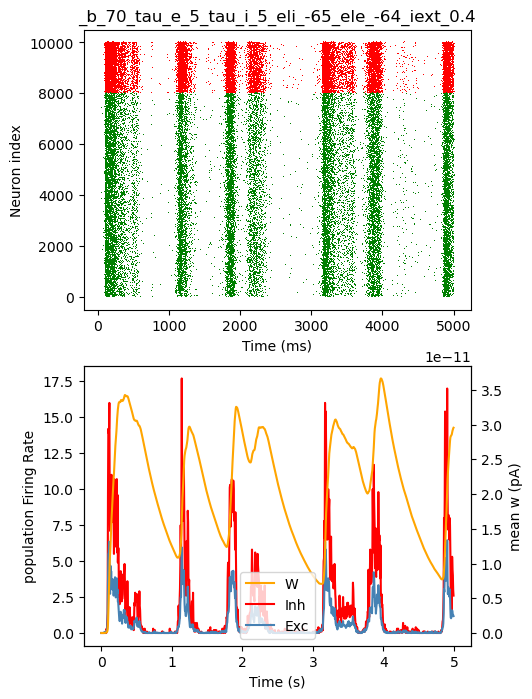

 done


In [93]:
%run adex_simulation_network.py --time 5000 --kwargs '{"use":True, "b_e":70}' --iext 0.4 --cells 'FS-RS_10'

<a id="fit-of-the-transfer-function"></a>
### Fit of the Transfer Function 

First we have to run the simulations of the single neurons. 

In the `tf_simulation` we can set:
1. the cell types - chosen from the file `cell_library.py` (we can add new parameters). To run parallel 2 different types of cells, run the script "`tf_simulation.py`", otherwise to run one single type of cells run the script "`tf_simulation_single_cell.py`"
2. the range of the inhibitory and excitatory input (in the form of [start, end, step])
3. the time of the simulation
4. the path (`save_path`) where the results will be saved, and a characteristic string to save in the names (`save_name`)

In [49]:
%run Tf_calc/tf_simulation.py --help

usage: tf_simulation.py [-h] [--cells CELLS] [--range_inh RANGE_INH]
                        [--range_exc RANGE_EXC] [--time TIME]
                        [--save_name SAVE_NAME]

optional arguments:
  -h, --help            show this help message and exit
  --cells CELLS         cell types of the populations (default: FS-RS)
  --range_inh RANGE_INH
                        inhibitory input values (default: 0.1,30,60)
  --range_exc RANGE_EXC
                        excitatory input values (default: 0.1,30,60)
  --time TIME           Total Time of simulation (ms) (default: 10000)
  --save_name SAVE_NAME
                        name to save (default: trial)


In [5]:
# Now making the numerical simulations at various levels of both excitatory and inhibitory inputs
%run Tf_calc/tf_simulation.py --cells FS-RS --range_inh 0.1,30,50 --range_exc 0.1,30,50 --time 4000 


rate exc = 0.1
rate inh = 0.1


WARNING    'Cm' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 200. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Cm' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 200. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


rate inh = 0.710204081632653


WARNING    'Cm' is an internal variable of group 'neurongroup_3', but also exists in the run namespace with the value 200. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Cm' is an internal variable of group 'neurongroup_4', but also exists in the run namespace with the value 200. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


rate inh = 1.3204081632653062
rate inh = 1.9306122448979592
rate inh = 2.5408163265306123
rate inh = 3.1510204081632653
rate inh = 3.7612244897959184
rate inh = 4.371428571428571
rate inh = 4.981632653061224
rate inh = 5.591836734693877
rate inh = 6.20204081632653
rate inh = 6.812244897959183
rate inh = 7.422448979591836
rate inh = 8.03265306122449
rate inh = 8.642857142857142
rate inh = 9.253061224489796
rate inh = 9.863265306122448
rate inh = 10.4734693877551
rate inh = 11.083673469387755
rate inh = 11.693877551020408
rate inh = 12.30408163265306
rate inh = 12.914285714285713
rate inh = 13.524489795918367
rate inh = 14.13469387755102
rate inh = 14.744897959183673
rate inh = 15.355102040816325
rate inh = 15.965306122448979
rate inh = 16.575510204081635
rate inh = 17.185714285714287
rate inh = 17.79591836734694
rate inh = 18.406122448979595
rate inh = 19.016326530612247
rate inh = 19.6265306122449
rate inh = 20.23673469387755
rate inh = 20.846938775510203
rate inh = 21.45714285714286
r

Fit the Transfer Function to the data. Separate fits need to be made for each type of cells. 

To set the parameters of the fit, check the documentation strings of the function `make_fit_from_data` 

Fit first the one type of cell and then the other (in our case FS and RS).

In [122]:
from Tf_calc.theoretical_tools import  make_fit_from_data
cell = 'FS'
pts = 50 #number of points that were used for the 'experiments'
save_name = 'trial'

file = f'./Tf_calc/data/ExpTF_{pts}x{pts}_{save_name}_{cell}.npy'

adapt_file= f"./Tf_calc/data/{pts}x{pts}_{save_name}_{cell}_adapt.npy"

param_file = f'./Tf_calc/data/{pts}x{pts}_{save_name}_{cell}_params.npy'
adapt_file=f"./Tf_calc/data/{pts}x{pts}_{save_name}_{cell}_adapt.npy"

P = make_fit_from_data(file, cell, param_file, adapt_file,range_exc=(0,5), range_inh=(0,5), 
window=20, loop_n=1, vthr_tol=1e-15,tf_tol=1e-18, w_prec=False)

(2500,) (2500,) (2500,) (2500,)
(2500,)
this many nans: 1391
(1109,)
fitting first order V threshold..
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.6385664486660224e-07
            Iterations: 67
            Function evaluations: 740
            Gradient evaluations: 67
P =  [-0.05092796  0.00233983  0.01278095 -0.00172311  0.00015008  0.01668248
  0.00621699 -0.00751524  0.00150705  0.00493844]
Fitting Transfer Function..
loop n: 0
(256,)
(50, 50)
coefficients saved in  ./data/50x50_trial_FS_fit.npy


We can check the fit of the Transfer Function

(50, 50)


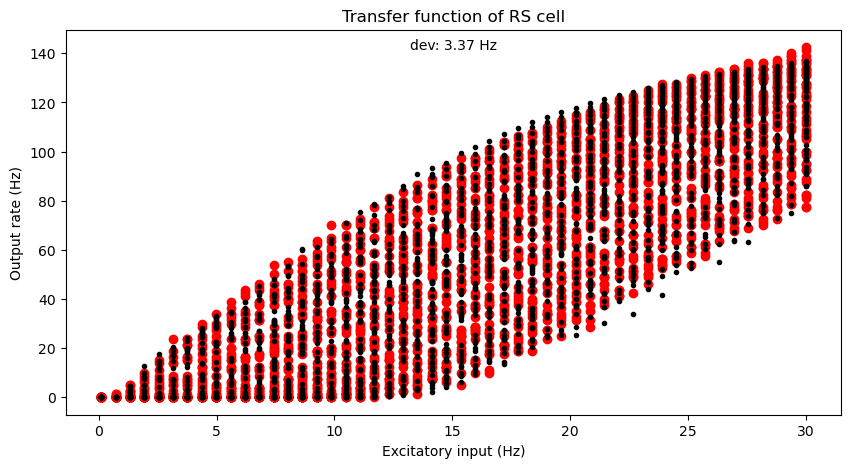

In [110]:
cell = 'RS'
pts = 50
save_name = 'trial'

file = f'./Tf_calc/data/ExpTF_{pts}x{pts}_{save_name}_{cell}.npy'
adapt_file= f"./Tf_calc/data/{pts}x{pts}_{save_name}_{cell}_adapt.npy"
file_fit =f"./Tf_calc/data/{pts}x{pts}_{save_name}_{cell}_fit.npy"

# file_fit ='FS-cell_CONFIG1_fit.npy'
param_file = f'./Tf_calc/data/{pts}x{pts}_{save_name}_{cell}_params.npy'

P = np.load(file_fit)
plot_check_fit(file, param_file, adapt_file ,cell, P, w_prec=False)

(50, 50)
(50, 50)


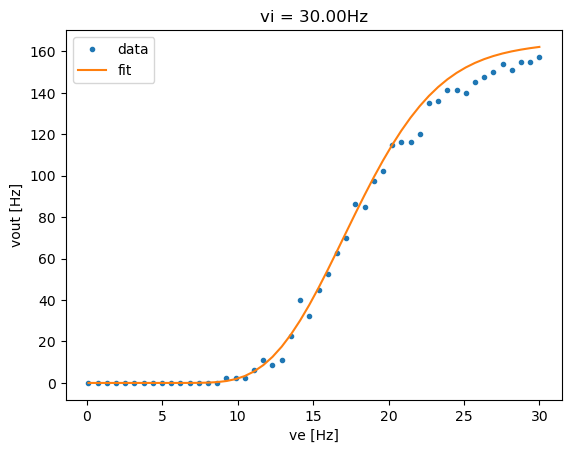

In [101]:
cell = 'FS'
pts = 50
save_name = 'trial'
# cell_sm = 'inh'
file = f'./Tf_calc/data/ExpTF_{pts}x{pts}_{save_name}_{cell}.npy'

adapt_file= f"./Tf_calc/data/{pts}x{pts}_{save_name}_{cell}_adapt.npy"
file_fit =f"./Tf_calc/data/{pts}x{pts}_{save_name}_{cell}_fit.npy"
# file_fit ='FS-cell_CONFIG1_fit.npy'
# file_fit ='RS-cell0_CONFIG1_fit.npy'
param_file = f'./Tf_calc/data/{pts}x{pts}_{save_name}_{cell}_params.npy'

P = np.load(file_fit)
video_check_fit(file, param_file, adapt_file ,cell, P, w_prec=True)

In [123]:
import subprocess

# Define a list of input values
input_values = [0.5, 2.5, 5, 7.5, 10, 15, 20, 25]

# Loop through the input values and run the script with each value
for input_value in input_values:
    command = f"python adex_simulation_network.py --input {input_value} --time 2000 --save_path './Tf_calc/net_compar/' "
    subprocess.run(command, shell=True)


[-0.05177874  0.00488156  0.01937205 -0.00168545  0.00023419  0.03484416
  0.00840215 -0.00479277 -0.00332084 -0.05583758]
cell parameters in SI units


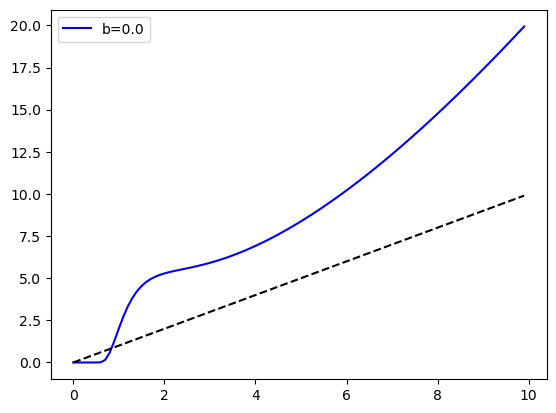

WARNING    /DATA/Maria/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.

 [py.warnings]


2024-05-27 19:34:00,901 - WARNING - py.warnings - /DATA/Maria/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.


solution =  [3.4854523]
solution nui_fix =  [[8.15757479]]


In [66]:
file_fs= 'FS-cell_CONFIG1_fit.npy'
file_fs= "./Tf_calc/data/{0}x{1}_{2}_{3}_fit.npy".format(50,50, 'trial', 'FS' )
file_rs ='RS-cell0_CONFIG1_fit.npy'
pts=50
save_name = 'trial'
cell='RS'
file_rs =f"./Tf_calc/data/{pts}x{pts}_{save_name}_{cell}_fit.npy"


plot_curve(NAME = 'FS-RS', file_rs =file_rs, file_fs= file_fs, 
               use_new=True, b_e=0e-12)

In [69]:
CELLS = 'FS-RS'
path_net = "./Tf_calc/net_compar/"
fr_both, inputs = load_network_mean(CELLS, path_net)


In [70]:
PRS = np.load(file_rs)
PFS = np.load(file_fs)
PFS = np.load("FS-cell_CONFIG1_fit.npy")
PRS = np.load("RS-cell0_CONFIG1_fit.npy")

calculate_mf_difference(CELLS, fr_both, inputs, PRS, PFS)

NameError: name 'run_MF' is not defined

<a id="mean-field-model"></a>
### Mean Field Model

In [53]:
%run MF_script_with_OS.py --help

usage: MF_script_with_OS.py [-h] [--cells CELLS] [--b_e B_E] [--iext IEXT]
                            [--tau_e TAU_E] [--tau_i TAU_I] [--T T]
                            [--use_new USE_NEW] [--time TIME]
                            [--file_fs FILE_FS] [--file_rs FILE_RS]
                            [--input INPUT]

optional arguments:
  -h, --help         show this help message and exit
  --cells CELLS      cell types of the populations (default: FS-RS)
  --b_e B_E          adaptation - in pA (default: 0.0)
  --iext IEXT        external input - in Hz (default: 0.3)
  --tau_e TAU_E      excitatory synaptic decay - in ms (default: 5.0)
  --tau_i TAU_I      inhibitory synaptic decay - in ms (default: 5.0)
  --T T              time constant - in ms (default: 20.0)
  --use_new USE_NEW  use input parameters - if False: will use the ones in
                     params file (default: True)
  --time TIME        Total Time of simulation - in s (default: 10)
  --file_fs FILE_FS  fit for fs (defa

In [69]:
file_fs

'./data/50x50_trial_FS_fit.npy'

In [88]:
file_fs = "FS-cell_CONFIG1_fit.npy"
file_rs = "RS-cell0_CONFIG1_fit.npy"

cell parameters in SI units
plat= 900
starting
done


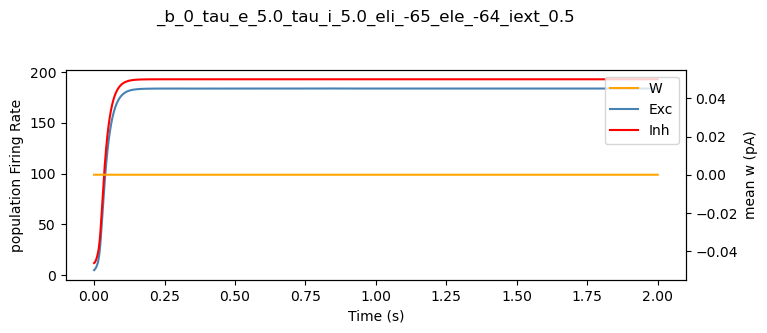

In [67]:
b_e=0
time = 2
iext=0.5

command = f"MF_script_with_OS.py --b_e {b_e} --time {time} --file_fs {file_fs} --file_rs {file_rs} --iext {iext}"

%run $command

starting
done


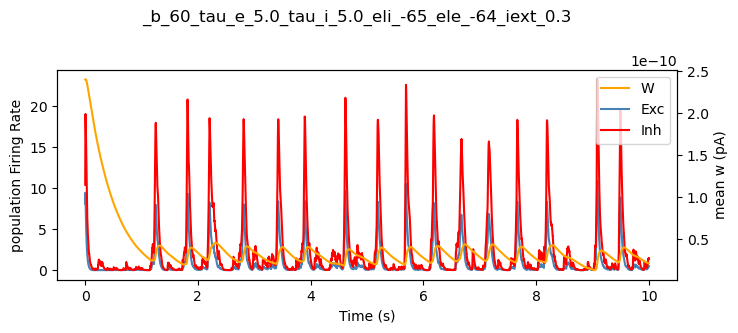

In [14]:
%run MF_script_with_OS.py --b_e=60

<a id="whole-brain-model"></a>
### Whole Brain Model

#### Choose a connectome 

You have various options:

1. Get a default connectivity from TVB software

    - `parameters.parameter_connection_between_region['default'] = True`

2. Point to a zip folder (required files included in the zip folder: centres, tract_lengths, weights)

    - `parameters.parameter_connection_between_region['from_file'] = True`
    - `parameters.parameter_connection_between_region['path'] = path/to/zip/file`
    - `parameters.parameter_connection_between_region['conn_name'] = 'Connectivity.zip'` (add the actual zip name)

3. Point to an h5 file

    - `parameters.parameter_connection_between_region['path'] = path/to/h5/file CHECK`

4. Point to an unzipped folder that contains necessarily tract_lengths.txt and weights.txt (optional: region_labels, centres, cortical)

    - `parameters.parameter_connection_between_region['path'] = path/to/folder/containing/files`


In [10]:
path_conn

'/DATA/Maria/paper_pipeline/tvb_model_reference/data/connectivity'

In [50]:
# Choose the connectome

cwd = os.getcwd()
path_conn = os.path.join(cwd, "TVB/tvb_model_reference/data/connectivity")
parameters.parameter_connection_between_region['from_file'] = True
parameters.parameter_connection_between_region['path'] = path_conn
parameters.parameter_connection_between_region['conn_name'] = 'connectivity_76.zip'

##### Set up the parameters of the simulation

In [12]:
## Set the parameters of the simulation:
run_sim = 4000.0 # ms, length of the simulation
cut_transient = 2000.0 # ms, length of the discarded initial segment

# List of values of adaptation strength and tau_e which will vary the brain state
bvals = [0]
tau_es = [5]

## Set the parameters of the stimulus (choose stimval = 0 to simulate spontaneous activity)
stimval = 0 #  stimulus strength

In [52]:
parameters.parameter_simulation['path_result'] = './TVB/result/synch/'

In [51]:
simulator = sim_init(parameters)
Nnodes = simulator.number_of_nodes

2024-05-27 19:01:39,939 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.


Overwriting...


#### Run the simulation


Here is an example of changing `tau_e` and `b_e`.

You can instead change `tau_i`, or other values (look at docs of `adjust_parameters`), by setting `tau_i = desired_value` as an argument in the functions:
- `adjust_parameters`
- `get_result`

and set `change_of = 'tau_i'` in:
- `access_results`
- `plot_tvb_results`



In [55]:
# Choose values of b_e and tau_e
bvals = [0, 100]
tau_es = [5, 5]
iext=0.315e-3
run_sim = 2000
cut_transient = 200

In [112]:
# Run Simulation
for b_e, tau_e in zip(bvals, tau_es):
    run_simulation_all(parameters, b_e = b_e, tau_e = tau_e,n_nodes=Nnodes,
                       cut_transient=cut_transient, run_sim=run_sim, Iext = iext)
    

Simulation Completed successfully


#### Load the Results

In [56]:
# Params to load 
bvals = [5, 60]
tau_es = [3.75, 5]

bvals = [5, 60]
tau_es = [3.75, 5]
iext=0.315e-3
#Which variables to load:
vars_int = ['E', 'I' ,'noise']

#Load
result= []
for i, (b_e, tau_e) in enumerate(zip(bvals, tau_es)):
    result_param, for_explan = get_result(parameters,cut_transient, run_sim, b_e = b_e, tau_e = tau_e, vars_int = vars_int,Iext = iext)
    result.append(result_param)


Loading:  _b_e_5_tau_e_3.75_tau_i_5.0_Iext_0.000315_El_e_-64.0_El_i_-65.0_nseed_10
monitors: 1
Loading:  _b_e_60_tau_e_5_tau_i_5.0_Iext_0.000315_El_e_-64.0_El_i_-65.0_nseed_10
monitors: 1


In [64]:
# For explanation of the indexes of the result, uncomment the following:

access_results(for_explan, bvals, tau_es, change_of='tau_e')


Explaining the indices in result:
The result has a length equal to you different parameter combinations, i.e:
result[0]: for b_e = 5 and tau_e= 3.75
result[1]: for b_e = 60 and tau_e= 5

The result[i] is a list of arrays, every element of a list corresponds to a monitor:
Raw monitor : result[i][0]

Each monitor contains an array with the selected variables of interest, for all the time points and nodes
For example for Raw monitor:
For E : result[i][0][0]
For I : result[i][0][1]
For noise : result[i][0][2]

These arrays have shape: time_points x number_of_nodes: (18001, 76)


#### Plot the Results

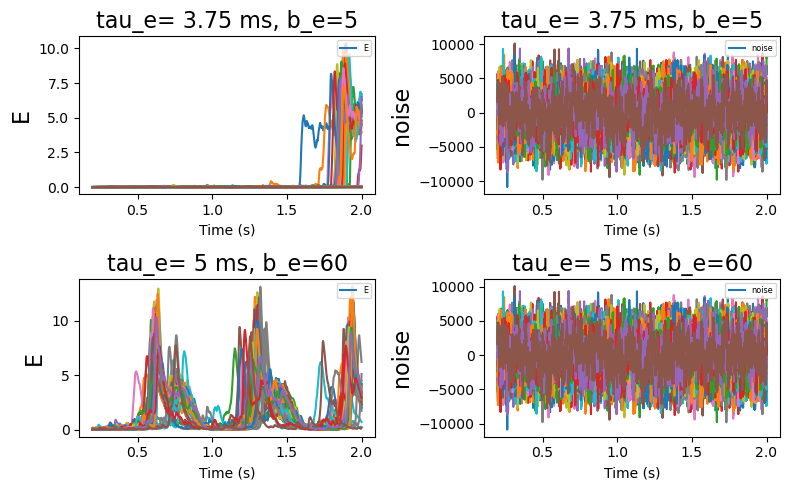

In [57]:
#Plot the results from TVB Simulations

#which monitor 
monitor = 'Raw'

#which variables
var_select = ['E',  'noise']

#which params (b_e, tau) - to be in the same order as the loading results (see explanations)
params = [[5, 3.75], [60,5]]
plot_tvb_results(parameters,params, result, monitor, for_explan, var_select,cut_transient, run_sim, Iext=iext)

<a id="pci"></a>
### Evoked Dynamics and PCI

#### Set up the parameters of the simulation

In [ ]:
## Set the parameters of the simulation:
run_sim = 4000.0 # ms, length of the simulation
cut_transient = 2000.0 # ms, length of the discarded initial segment

# List of values of adaptation strength and tau_e which will vary the brain state
bvals = [5]
tau_es = [3.75]

These are additional parameters to adjust for the stimulation

In [ ]:
## Set the parameters of the stimulus 
stimval = 1e-3 #  stimulus strength in kHz - HERE NO ZERO ANYMORE
t_analysis  = 300. #in ms, for PCI analysis

# Loop over seeds to obtain multi5ple realizations of the model
Nseeds = 2 

# Onset time of the stimulus
stimtime_allseeds = np.random.rand(Nseeds)*(run_sim - cut_transient - 2*t_analysis) + t_analysis + cut_transient # shuffle in ms the start time of stimulus 
stimdur = 50 # ms, duration of the stimulus
stimtime_mean = 2500. # ms, time after simulation start (it will be shufled)
stim_region = 5

#### Run Simulation

In [ ]:
# Choose values of b_e and tau_e
bvals = [5]
tau_es = [3.75]

In [ ]:
# Run Simulation
for b_e, tau_e in zip(bvals, tau_es):
    for seed in range(Nseeds):
        run_simulation_all(parameters, b_e = b_e, tau_e = tau_e,n_nodes=Nnodes,stimval = stimval, nseed=seed,
                       cut_transient=cut_transient, run_sim=run_sim)


#### Calculate PCI

In [ ]:
#Calculate PCI
params = [[5, 3.75, 2], [60, 5, 2]] 

for b_e, tau_e, n_seeds in params:
    calculate_PCI(parameters, n_seeds, run_sim, cut_transient, stimval=stimval, b_e=b_e, tau_e=tau_e, n_trials = 1)

#### Plot PCI #

Loading paper params:
For wake : b_e=5, tau=5.0
For nmda : b_e=30, tau=3.75
For gaba : b_e=30, tau=7.0
For sleep : b_e=120, tau=5.0
Seeds = 60, n_trials=5, stimvals=[1e-05, 0.0001, 0.001]
Creating PCI_all
Creating dataframe


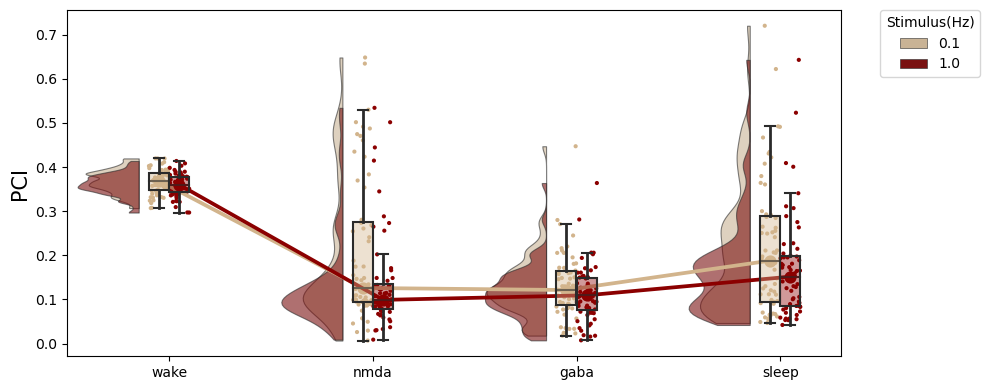

In [58]:
params = [[5, 3.75, 2], [60, 5, 2]] # b_e, tau, nseeds
conditions = ['nmda', 'sleep'] #conditions that the params describe - used for the x tick labels
stimvals = [1e-3] #stimvals to load
n_trials=1 #how many trials were used for the PCI

pick_stim = [1, 0.1] # stimulus strength to plot

#set this to True if you want to plot the already run stims, it will load params automatically
local_folder= True 


plot_raincloud_with_stats(parameters, params, n_trials=n_trials, stimvals=stimvals, pick_stim=pick_stim, conditions= conditions, local_folder=local_folder)

<a class="anchor" id="bold-and-fc"></a>
### Simulating BOLD signal and calculating FC-SC Correlation

#### Set up the parameters of the simulation

In [ ]:
# Do that to initialize the parameters
parameters.__init__()

In [5]:
# Choose the connectome

cwd = os.getcwd()
path_conn = os.path.join(cwd, "TVB/tvb_model_reference/data/connectivity")
parameters.parameter_connection_between_region['from_file'] = True
parameters.parameter_connection_between_region['path'] = path_conn
parameters.parameter_connection_between_region['conn_name'] = 'connectivity_76.zip'

For the BOLD monitor long simulations are needed, so set a long `run_sim`

In [6]:
## Set the parameters of the simulation:
run_sim = 100000 # ms, length of the simulation
cut_transient = 2000.0 # ms, length of the discarded initial segment

# List of values of adaptation strength and tau_e which will vary the brain state
bvals = [5]
tau_es = [3.75]

## Set the parameters of the stimulus (choose stimval = 0 to simulate spontaneous activity)
stimval = 0 #  stimulus strength

Set `parameter_monitor['Bold'] = True` 
- (if you want you can simulate another monitor)

In [7]:
#Set Bold Monitor
parameters.parameter_monitor['Bold'] = True
# parameters.parameter_monitor['parameter_Bold']['period'] = 2000 

#Deactivate Raw, and keep Temporal Average instead ( faster )
parameters.parameter_monitor['Raw'] = False
parameters.parameter_monitor['TemporalAverage'] = True
parameters.parameter_monitor['parameter_TemporalAverage']['variables_of_interest'] = [0,1]

In [60]:
# Choose values of b_e and tau_e
bvals = [5]
tau_es = [3.75]

#Set a subfolder where the results will be saved, otherwise they can be overwritten 
additional_path_folder='Bold/'

#### Run Simulation

In [ ]:
# Run sim


for b_e, tau_e in zip(bvals, tau_es):
    run_simulation_all(parameters, b_e = b_e, tau_e = tau_e,n_nodes=Nnodes,stimval = stimval, nseed=seed,
                cut_transient=cut_transient, run_sim=run_sim,additional_path_folder=additional_path_folder)


#### Load Results

In [62]:
# Params to load 
bvals = [5]
tau_es = [3.75]

#Which Variables to load
vars_int = ['E' ]

result= []
for i, (b_e, tau_e) in enumerate(zip(bvals, tau_es)):
    result_param, for_explan = get_result(parameters,cut_transient, run_sim, b_e = b_e, tau_e = tau_e, 
    vars_int = vars_int, additional_path_folder=additional_path_folder)
    result.append(result_param)


Loading:  _b_e_5_tau_e_3.75_tau_i_5.0_Iext_0.000315_El_e_-64.0_El_i_-65.0_nseed_10
monitors: 2


In [64]:
# For explanation of the indexes of the result, uncomment the following:
access_results(for_explan, bvals, tau_es, change_of='tau_e')



Explaining the indices in result:
The result has a length equal to you different parameter combinations, i.e:
result[0]: for b_e = 5 and tau_e= 3.75

The result[i] is a list of arrays, every element of a list corresponds to a monitor:
TemporalAverage monitor : result[i][0]
Bold monitor : result[i][1]

Each monitor contains an array with the selected variables of interest, for all the time points and nodes
For example for TemporalAverage monitor:
For E : result[i][0][0]

These arrays have shape: time_points x number_of_nodes: (1800, 76)


#### Plot Results


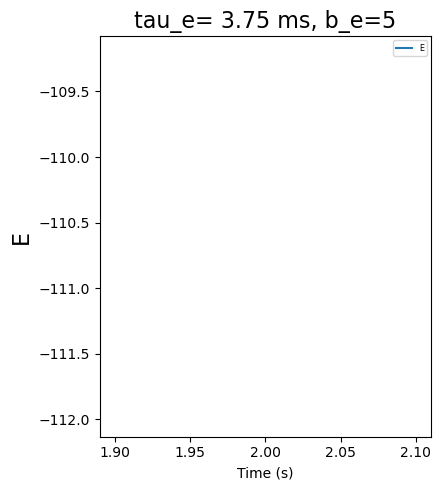

In [63]:
#Plot the results from TVB Simulations

#which monitor 
monitor = 'Bold'

#which variables to plot
var_select = ['E']

#which params (b_e, tau) - to be in the same order as the loading results (see explanations)
params = [[5, 3.75]]
plot_tvb_results(parameters,params, result, monitor, for_explan, var_select,cut_transient, run_sim, 
                 additional_path_folder=additional_path_folder, desired_time=10)

#### Compute Corr FC and SC

450 76


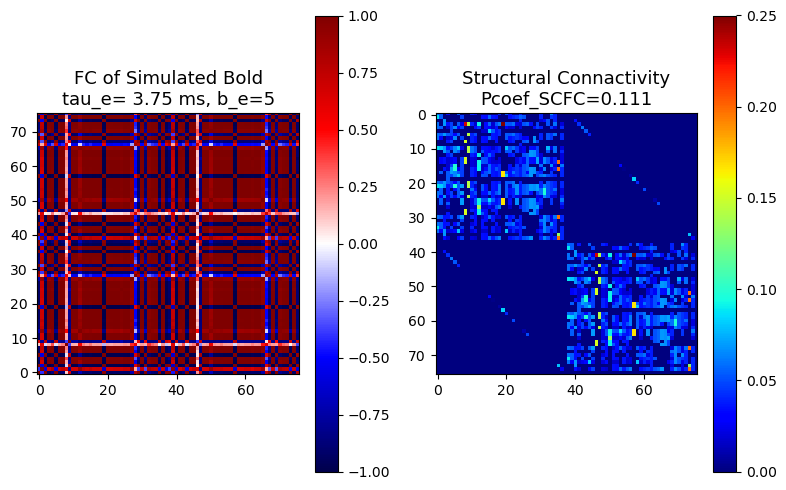

In [97]:
#Add the SC
SC=simulator.connectivity.weights

plot_FC_SC(parameters,params, result, for_explan, cut_transient, run_sim, SC, 
            additional_path_folder=additional_path_folder,desired_time=10)

<a class="anchor" id="dynamical-analysis"></a>
### Dynamical Analysis 

#### Network Simulations and Survival Time

1. First run network simulations for different values of tau_e/tau_i and b_e
2. Calculate the survival time for each combination of tau/b_e

In [59]:
%run net_sims_dyn_analysis.py --help

usage: net_sims_dyn_analysis.py [-h] [--b_e_range B_E_RANGE]
                                [--tau_e_range TAU_E_RANGE]
                                [--tau_i_range TAU_I_RANGE] [--nseeds NSEEDS]
                                [--time TIME] [--save_path SAVE_PATH]
                                [--overwrite OVERWRITE]
                                [--surv_time_calc SURV_TIME_CALC]

optional arguments:
  -h, --help            show this help message and exit
  --b_e_range B_E_RANGE
                        b_e range of values (default: 0,30,1)
  --tau_e_range TAU_E_RANGE
                        tau_e range of values - if you iterate tau_i then set
                        tau_e_range=np.arange(5.,10.,step=500) (default:
                        5.,7.,10)
  --tau_i_range TAU_I_RANGE
                        tau_i range of values - if you iterate tau_e then set
                        tau_i_range=np.arange(5.,10.,step=500) (default:
                        3.,9.,0.1)
  --nseeds NSEEDS  

In [61]:
%run net_sims_dyn_analysis.py --b_e_range '0,22,2' --tau_i_range '5, 5.5, 0.2' --nseeds '0,4,2' --surv_time_calc True --save_path './trials/'

Done! Network simulations are saved in ./trials//network_sims/ 
survival time (tau_i_mean_array.npy) 
with the respective values of b_e (tau_i_heatmap_bvals.npy) and 
tau_i (tau_i_heatmap_taus.npy) in ./trials/


You can separately calculate the survival times if you have already run the network simulations:
- adjust the parameters accordingly

In [55]:
bvals = np.arange(0,22,step=2)
tauIv = np.arange(5.,5.5,step=0.2)
tauEv= np.arange(5.,9.,step=10)
Nseeds = np.arange(0,4,2)

if len(tauEv)==1 and len(tauIv)>1:
    tau_i_iter = True
    tau_values = tauIv
elif len(tauEv)>1 and len(tauIv)==1:
    tau_i_iter = False
    tau_values = tauEv

calculate_survival_time(bvals, tau_values, tau_i_iter, Nseeds, save_path ='./trials/')


Done! Saved in : ./trials/


#### Mean Field and b_critical Calculation


In [73]:
%run calculate_b_crit.py --help

usage: calculate_b_crit.py [-h] [--b_e_range B_E_RANGE]
                           [--tau_e_range TAU_E_RANGE]
                           [--tau_i_range TAU_I_RANGE] [--save_path SAVE_PATH]
                           [--overwrite OVERWRITE]

optional arguments:
  -h, --help            show this help message and exit
  --b_e_range B_E_RANGE
                        b_e range of values (default: [ 0 1 2 3 4 5 6 7 8 9 10
                        11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
                        29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
                        47 48 49 50 51 52 53 54 55 56 57 58 59])
  --tau_e_range TAU_E_RANGE
                        tau_e range of values - if you iterate tau_i then set
                        tau_e_range=np.arange(5.,10.,step=500) (default: [5.])
  --tau_i_range TAU_I_RANGE
                        tau_i range of values - if you iterate tau_e then set
                        tau_i_range=np.arange(5.,10.,step=500) (def

In [21]:
%run calculate_b_crit.py --tau_i_range '5,7,0.2' --overwrite=True --save_path='./trials/' 

5.0 5.0
crit b =  20
5.2 5.0
crit b =  18
5.4 5.0
crit b =  16
5.6000000000000005 5.0
crit b =  13
5.800000000000001 5.0
crit b =  11
6.000000000000001 5.0
crit b =  9
6.200000000000001 5.0
crit b =  7
6.400000000000001 5.0
crit b =  5
6.600000000000001 5.0
crit b =  3
6.800000000000002 5.0
crit b =  2


#### Plot the heatmap

In [48]:
#This is an example with few values of tau_i and b_e
load= 'tau_i'
mean_array,taus, bthr, tau_v, bvals = load_survival( load = load, save_path='./trials/')
plot_heatmap_survival(mean_array, taus, tau_v, bvals , bthr,load = load, save_im=False, z_max=200, precalc=False, line_color='yellow')

Or you can load directly a pre-calculated array with the mean survival time (averaged over seeds) for each combination of tau/b_e : 

In [45]:
load= 'tau_e'
mean_array,taus, bthr, tau_v, bvals = load_survival( load = load, precalc=True)
plot_heatmap_survival(mean_array, taus, tau_v, bvals , bthr,load = load, precalc=True, save_im=False, z_max=200, line_color='black', colorscale="jet") 